In [1]:

# Pytorch - for build and train network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# for the classifiers also the cluster.
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# for the classification evaluation.
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# handel the imbalanced dataset us  SMOTE method
from imblearn.over_sampling import SMOTE
from collections import Counter

from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm.notebook import tqdm

import pickle
import math

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re

import os
cwd = os.getcwd()

## Data preproces - clean / vectorize / banlance the train label

#### clean the data

In [2]:
# READ THE DATA

df = pd.read_excel(cwd+"/tamedia 1000 transcripts to label 2024-06-08.xlsx", index_col=0)
df.head()

,motive_final,textAno4
ID,,
1,"Ratsuche (0.5), Vertrauen (0.5)","SPEAKER_A : Ich glaube , bei der Berner Zeitun..."
2,Keine,"SPEAKER_B : Berner Zeitung , Aboservice , {nam..."
3,Preisoptimierung (1),SPEAKER_A : Finanz und Wirtschaft . Mein Name ...
4,Vertrauen (1),"SPEAKER_A : Schweizer Familie , Aboservice , {..."
5,"Vertrauen (0.5), Abgabe (0.5)","SPEAKER_A : Guten Tag , hier ist {name} von de..."


In [3]:
# Define a function to split, expand motive types, and remove probabilities
def split_and_expand_motive_types(row):
    text = str(row['motive_final'])  # Ensure motive_final is treated as a string
    if text == 'Keine' or text.lower() == 'nan':
        return [row]  # Return the row unchanged if the text is exactly '0' or 'NaN'

    matches = re.findall(r'(\w+)\s*\(\d*\.?\d*\)', text)  # Extract just the motive name, ignoring the probability
    if matches:
        # Generate a new row for each motive type without the probability
        expanded_rows = []
        for match in matches:
            new_row = row.copy()
            new_row['motive_final'] = match  # Set the motive name without the probability
            expanded_rows.append(new_row)
        return expanded_rows
    else:
        return [row]  # Return the original row if no matches found

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([expanded_row for index, row in df.iterrows() for expanded_row in split_and_expand_motive_types(row)])
# print(expanded_df.motive_final.unique())
# print(expanded_df.shape)
# expanded_df.head()



######
'''
['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0.5 Selbermachen, 0.5 Keine' 'Keine '
 'Abgabe  ' 'Preisoptimierer' 'Selbermachen 0.5, Ratsuche 0.5' nan]
(1079, 2)

'''
df = expanded_df
df['motive_final'] = df['motive_final'].fillna('0')
df['motive_final'] = df['motive_final'].replace('Keine ', 'Keine')
df['motive_final'] = df['motive_final'].replace('Abgabe  ', 'Abgabe')
df['motive_final'] = df['motive_final'].replace('Preisoptimierer', 'Preisoptimierung')
# print(expanded_df.motive_final.unique())
# print(expanded_df.shape)
# expanded_df.head()

'''
array(['Ratsuche', 'Vertrauen', 'Keine', 'Preisoptimierung', 'Abgabe',
       'Pragmatismus', 'Selbermachen', 'Vermeidung',
       '0.5 Selbermachen, 0.5 Keine', 'Selbermachen 0.5, Ratsuche 0.5',
       '0'], dtype=object)

'''
# Define a function to split, expand motive types, and handle specific cases
def split_and_expand_motive_types2(row):
    text = str(row['motive_final'])  # Ensure motive_final is treated as a string
    if text == '0' or text.lower() == 'nan':
        return [row]  # Return the row unchanged if the text is exactly '0' or 'NaN'

    expanded_rows = []

    # Handle the specific case "Selbermachen 0.5, Ratsuche 0.5"
    if text == 'Selbermachen 0.5, Ratsuche 0.5':
        motives = ['Selbermachen', 'Ratsuche']
    # Handle the specific case "0.5 Selbermachen, 0.5 n/a"
    elif text == '0.5 Selbermachen, 0.5 Keine':
        motives = ['Selbermachen', 'Keine']
    else:
        # Generic handling: Extract motive names without probabilities
        motives = re.findall(r'(\w+)\s*\d*\.?\d*', text)

    # Generate a new row for each motive name without the probability
    for motive in motives:
        new_row = row.copy()
        new_row['motive_final'] = motive  # Set the motive name without the probability
        expanded_rows.append(new_row)

    return expanded_rows

# Apply the function and expand the DataFrame
expanded_df = pd.DataFrame([expanded_row for index, row in df.iterrows() for expanded_row in split_and_expand_motive_types2(row)])
print(expanded_df.motive_final.unique())
print(expanded_df.shape)
expanded_df.head()

''' 
['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0']
(1081, 2)

'''
df = expanded_df


['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0']
(1081, 2)


In [4]:
# Replace '\n' with ' ' in the 'textAno4' column
df['textAno4'] = df['textAno4'].str.replace('\n', ' ')

# Extract unique placeholders
unique_placeholders = set(re.findall(r'\{([^}]+)\}', ' '.join(df['textAno4'])))
# print(unique_placeholders)
'''
{
' e-mail ', ' number ', ' town ',
 ' street { street name ', ' street name ', 
 ' address ', 'name', ' { e-mail '
 }
'''
# Extract unique speaker identifiers
unique_speakers = set(re.findall(r'([A-Z_]+)\s*:', ' '.join(df['textAno4'])))
# print(unique_speakers)
'''
{
'SPEAKER_A', 'SPEAKER_D', 
'SPEAKER_C', 'SPEAKER_UNKNOWN', 
'SPEAKER_B'
}
'''


translations = {}

# Translate each placeholder
translations[' street { street name '] = 'Strassenname'
translations[' street name '] = 'Strassenname'
translations[' number '] = 'Nummer'
translations[' address '] = 'Adresse'
translations[' { e-mail '] = 'E-Mail'
translations[' e-mail '] = 'E-Mail'
translations['name'] = 'Name'
translations[' town '] = 'Stadt'

# Translate each speaker
translations['SPEAKER_A'] = 'SPRECHER_A'
translations['SPEAKER_B'] = 'SPRECHER_B'
translations['SPEAKER_C'] = 'SPRECHER_C'
translations['SPEAKER_D'] = 'SPRECHER_D'
translations['SPEAKER_UNKNOWN'] = 'SPRECHER_UNBEKANNT'

# Replace placeholders in DataFrame
for eng_placeholder, ger_translation in translations.items():
    df['textAno4'] = df['textAno4'].str.replace(eng_placeholder, ger_translation)

# Replace speakers in DataFrame
for eng_speaker, ger_speaker in translations.items():
    df['textAno4'] = df['textAno4'].str.replace(eng_speaker, ger_speaker)

# print (set(re.findall(r'\{([^}]+)\}', ' '.join(df['textAno4']))))
# print (set(re.findall(r'([A-Z_]+)\s*:', ' '.join(df['textAno4']))))
# df.head()
print(df.motive_final.unique())

#rename the columns name
df.rename(columns={'textAno4': 'text','motive_final':'label'}, inplace = True)
print(df.head())
print(df.shape)

df = df.drop_duplicates(subset='text', keep="first")
print(df.head())
print(df.shape)

['Ratsuche' 'Vertrauen' 'Keine' 'Preisoptimierung' 'Abgabe' 'Pragmatismus'
 'Selbermachen' 'Vermeidung' '0']
              label                                               text
1          Ratsuche  SPRECHER_A : Ich glaube , bei der Berner Zeitu...
1         Vertrauen  SPRECHER_A : Ich glaube , bei der Berner Zeitu...
2             Keine  SPRECHER_B : Berner Zeitung , Aboservice , {Na...
3  Preisoptimierung  SPRECHER_A : Finanz und Wirtschaft . Mein Name...
4         Vertrauen  SPRECHER_A : Schweizer Familie , Aboservice , ...
(1081, 2)
              label                                               text
1          Ratsuche  SPRECHER_A : Ich glaube , bei der Berner Zeitu...
2             Keine  SPRECHER_B : Berner Zeitung , Aboservice , {Na...
3  Preisoptimierung  SPRECHER_A : Finanz und Wirtschaft . Mein Name...
4         Vertrauen  SPRECHER_A : Schweizer Familie , Aboservice , ...
5         Vertrauen  SPRECHER_A : Guten Tag , hier ist {Name} von d...
(999, 2)


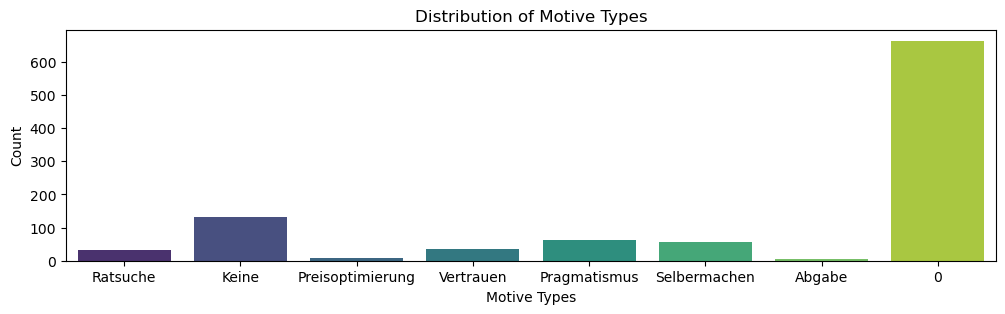

Counter({'0': 664,
         'Keine': 133,
         'Pragmatismus': 63,
         'Selbermachen': 58,
         'Vertrauen': 34,
         'Ratsuche': 33,
         'Preisoptimierung': 9,
         'Abgabe': 5})

In [5]:
plt.figure(figsize=(12, 3))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribution of Motive Types')
plt.xlabel('Motive Types')
plt.ylabel('Count')
plt.show()
Counter(df.label)

In [6]:
# remove the Vermeidung / Abgabe/Preisoptimierung class, it was too less for training.
df = df[df['label'] != "Abgabe"]
df = df[df['label'] != "Preisoptimierung"]
df_l = df[df['label'] != "0"]
df_ul = df[df['label'] == "0"]
Counter(df_ul.label)

Counter({'0': 664})

In [7]:
Counter(df_l.label)

Counter({'Keine': 133,
         'Pragmatismus': 63,
         'Selbermachen': 58,
         'Vertrauen': 34,
         'Ratsuche': 33})

#### Vectorize - TFIDF


In [8]:
from sklearn.preprocessing import LabelEncoder
# label encoder
le = LabelEncoder()   ### ENCODE

y_encoded = le.fit_transform(df_l.label)

"""

# Decode labels back to original form if needed
y_resampled_decoded = le.inverse_transform(y_resampled)

"""


X_l = df_l.text
X_ul = df_ul.text


vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words=None,
)
t0 = time()
X_l_tfidf = vectorizer.fit_transform(X_l)
X_ul_tfidf = vectorizer.fit_transform(X_ul)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_l_tfidf.shape[0]}, n_features: {X_l_tfidf.shape[1]}")

# feature reduction
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()


X_l_lsa = lsa.fit_transform(X_l_tfidf)
X_ul_lsa = lsa.fit_transform(X_ul_tfidf)

explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")



vectorization done in 0.103 s
n_samples: 321, n_features: 840
LSA done in 0.091 s
Explained variance of the SVD step: 50.7%


#### SMOTE banlance data and splite the label data.

splite the labeld dataset to 50% train(reset) and test dataset.

In [9]:
# 
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_l_lsa, y_encoded, test_size=0.5, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


# Check distribution
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_resampled))
print("Before SMOTE:", X_train.shape)
print("After SMOTE:", X_resampled.shape)
print("X_test:", X_test.shape)
print("X_ul:", X_ul_lsa.shape)


# X_resampled = torch.from_numpy(X_resampled).to(torch.float32).reshape(1, -1)
# X_test = torch.from_numpy(X_test).to(torch.float32).reshape(1, -1)
# X_ul_lsa = torch.from_numpy(X_ul_lsa).to(torch.float32).reshape(1, -1)



Before SMOTE: Counter({0: 64, 1: 34, 3: 28, 4: 17, 2: 17})
After SMOTE: Counter({4: 64, 3: 64, 0: 64, 1: 64, 2: 64})
Before SMOTE: (160, 100)
After SMOTE: (320, 100)
X_test: (161, 100)
X_ul: (664, 100)


## Define CoRL environment   /CLFS / ENVS / RLm-Actor created networks

In [10]:

# Initialize classifiers (KNN and SVM)
knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
svm = SVC(kernel='rbf', probability=True, tol=1e-4, max_iter=10000, C=1.0)
classifiers = [knn, svm]

In [11]:
# define ENV

# for clustering the unlabeld data



class Env():
    def __init__(self, classifiers, input_ul_data, k, X_test, y_test, X_reset, y_reset):
        # super().__init__
        self.models = classifiers
    
        # UN LABEL DATA
        self.X_ul = input_ul_data
        # define the evaluate data, later use for the reward
        self.X_eval = X_test
        self.y_eval = y_test
        self.X_reset = X_reset
        self.y_reset = y_reset
        # cluster the data
        self.action_size = k
        self.kmeans = KMeans(n_clusters=k,  n_init=10)
        self.cluster_label = self.kmeans.fit_predict(self.X_ul)
        self.u_cluster_label = np.unique(self.cluster_label)
        self.centroids = self.kmeans.cluster_centers_
        self.observation_size = self.get_state(reset=True).shape[1]
        self.prev_macro_f1 = 0.0

    # update 2 clf
    def train_2_clf(self, X, y):
        self.models[0].fit(X, y)
        self.models[1].fit(X, y)

    def get_state(self, reset=False):
        """
        Generate a state representation by predicting probabilities on centroids using stored models.
        Optionally resets and retrains models using X_reset and y_reset.

        :param reset: Boolean flag to reset and retrain models before prediction.
        :return: Torch tensor of concatenated probabilities reshaped as (1, -1).
        """
        if reset:
            if self.X_reset is not None and self.y_reset is not None:
                self.train_2_clf(self.X_reset, self.y_reset)
            else:
                raise ValueError("Reset datasets X_reset or y_reset are not provided.")
        
        if not hasattr(self, 'models') or len(self.models) < 2:
            raise ValueError("Model list is incomplete or not set.")

        try:
            out_1 = self.models[0].predict_proba(self.centroids)
            out_2 = self.models[1].predict_proba(self.centroids)
        except Exception as e:
            raise RuntimeError("Model prediction failed: " + str(e))
        
        state_proba = np.concatenate((out_1, out_2), axis=1)
        return torch.from_numpy(state_proba).to(torch.float32).reshape(1, -1)


    def get_f1(self):
        classifier_weights = [clf.score(self.X_eval, self.y_eval) for clf in [self.models[0], self.models[1]]]  # Weights based on validation accuracy
        combined_probabilities = np.average(
            [clf.predict_proba(self.X_eval) for clf in [self.models[0], self.models[1]]],
            axis=0,
            weights=classifier_weights
        )

        # Get final predictions from combined probabilities
        combined_predictions = np.argmax(combined_probabilities, axis=1)


        # Calculate F1 scores per class (harmonic means)
        f1_macro = f1_score(self.y_eval, combined_predictions, average='macro')
        f1_micro = f1_score(self.y_eval, combined_predictions, average='micro')

        # Compute Macro-F1 as arithmetic mean of F1 scores
        macro_f1 = np.mean(f1_macro)
        micro_f1 = np.mean(f1_micro)
        return macro_f1, micro_f1

    ######
    ######
    def get_subset(self, action):
        # choose subset
        subset = self.X_ul[self.cluster_label == action]
        return subset

    def co_training(self, subset):

        # Average class probabilities across classifiers
        avg_probabilities = np.mean([clf.predict_proba(subset) for clf in self.models], axis=0)

        # Assign the label with the highest average probability
        y_ul_action = np.argmax(avg_probabilities, axis=1)
        # print(y_ul_action)

        ########### update the label_set for traning
        X_updated = np.concatenate((self.X_reset, subset), axis=0)
        y_updated = np.concatenate((self.y_reset, y_ul_action), axis=0)

        ############# use the updated labeld dateset retrain those 2 classifier
        self.train_2_clf(X_updated, y_updated)

       
        return self.get_f1()

    def step(self, action):
        # GET THE bigining state accuracy, later use to calculate the reward
        macrof1, microf1 = self.get_f1()

        # choose subset
        choosen_subset =  self.get_subset(action)


        # cotraining the 2 classifier
        new_marco_f1, new_micro_f1 = self.co_training(choosen_subset)

        # get the next state_
        n_state = self.get_state()

        ##############
        # calculate the reward
        ##############
        if new_marco_f1 > macrof1:
            reward_0 = new_marco_f1 - macrof1
        else:
            reward_0 = 0

        return n_state, reward_0, new_marco_f1, new_micro_f1


In [12]:
k = 400
env = Env(classifiers=classifiers, input_ul_data=X_ul_lsa, k=k, X_test=X_test, y_test=y_test, X_reset=X_resampled, y_reset=y_resampled)

env.get_f1()


(0.3587652926783361, 0.4906832298136646)

In [13]:
# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        # Shared layers
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # Actor: outputs action probabilities (softmax)
        self.actor = nn.Linear(128, action_size)


        # Critic: outputs state value (for advantage calculation)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Policy (actor): softmax over actions
        action_probs = torch.softmax(self.actor(x), dim=-1)

        # Value (critic): state value estimation
        state_value = self.critic(x)

        return action_probs, state_value

In [14]:


actor_critic = ActorCritic(state_size=env.observation_size, action_size=env.action_size)
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)
# Training parameters
num_episodes = 200
gamma = 0.99
results = []

In [15]:

episode_rewards = []
episode_f1s = []
macro_f1_scores = []
micro_f1_scores = []

# Main training loop


for episode in tqdm(range(num_episodes)):
    state = env.get_state(reset=True)
    # state = torch.FloatTensor(state).unsqueeze(0)  # Shape adjustment for single sample
    episode_reward = 0
    episode_loss = 0.00

    for t in range(1, 400):  # Limit the number of time steps
        # No need to use GradientTape; PyTorch handles gradients automatically
        # Choose an action using the actor
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()


        # Take the chosen action and observe the next state and reward
        next_state, reward, macro_f1, micro_f1 = env.step(action.item())
        # next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # print(f" t: {t}  next_state.shape {next_state.shape} ")

        # Compute the advantage
        # _, state_value = actor_critic(state)
        _, next_state_value = actor_critic(next_state)
        advantage = reward + gamma * next_state_value - state_value

        # Compute actor and critic losses
        actor_loss = -dist.log_prob(action) * advantage.detach()
        critic_loss = advantage.pow(2)

        # Combine losses for joint update
        total_loss = actor_loss + critic_loss

        # Update actor and critic
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        state = next_state
        episode_reward += reward
        episode_loss += total_loss
        episode_f1s.append(macro_f1)
        if episode == num_episodes - 1:
            macro_f1_scores.append(macro_f1)
            micro_f1_scores.append(micro_f1)

    episode_rewards.append(episode_reward)

    if episode % 10 == 0:
        print(f" Episode {episode}, Reward: {episode_reward}  AC losses:{episode_loss}")
results.append([episode_rewards, episode_f1s, macro_f1_scores, micro_f1_scores])

  0%|          | 0/200 [00:00<?, ?it/s]

 Episode 0, Reward: 2.4677714561000283  AC losses:tensor([[2.1732]], grad_fn=<AddBackward0>)
 Episode 10, Reward: 2.3051267310352195  AC losses:tensor([[0.0185]], grad_fn=<AddBackward0>)
 Episode 20, Reward: 2.2660253290621553  AC losses:tensor([[0.0179]], grad_fn=<AddBackward0>)
 Episode 30, Reward: 2.8466616398691165  AC losses:tensor([[-2.9955]], grad_fn=<AddBackward0>)
 Episode 40, Reward: 2.3648739945683697  AC losses:tensor([[0.0361]], grad_fn=<AddBackward0>)
 Episode 50, Reward: 2.4938491682251818  AC losses:tensor([[0.0372]], grad_fn=<AddBackward0>)
 Episode 60, Reward: 2.5201526589299066  AC losses:tensor([[0.0351]], grad_fn=<AddBackward0>)
 Episode 70, Reward: 2.4783427066835904  AC losses:tensor([[0.0389]], grad_fn=<AddBackward0>)
 Episode 80, Reward: 2.6184532770952873  AC losses:tensor([[0.0369]], grad_fn=<AddBackward0>)
 Episode 90, Reward: 2.490714286847349  AC losses:tensor([[0.0372]], grad_fn=<AddBackward0>)
 Episode 100, Reward: 2.373082994237575  AC losses:tensor([[0

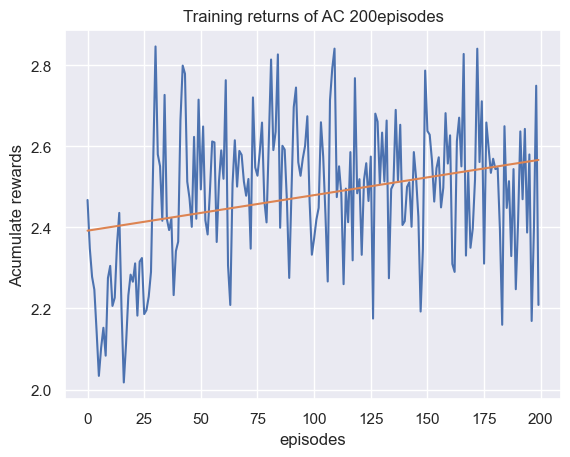

In [16]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(episode_rewards)
plt.ylabel('Acumulate rewards')
plt.xlabel('episodes')
plt.title(f'Training returns of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(episode_rewards)).reshape(-1, 1), np.array(episode_rewards).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(episode_rewards)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

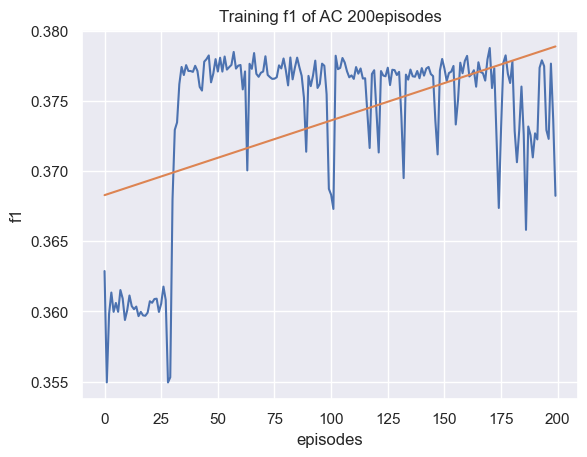

In [17]:


def calculate_averages(numbers):
  """Calculates the average of every 10 consecutive numbers in a list.

  Args:
    numbers: A list of numbers.

  Returns:
    A list of averages, each representing the average of 10 consecutive numbers.
  """

  averages = []
  for i in range(0, len(numbers), 400):
    chunk = numbers[i:i+400]
    average = sum(chunk) / len(chunk)
    averages.append(average)
  return averages

# # Example usage:
# my_list = [1, 2, 3, ..., 200]  # Replace with your actual list of 200 numbers
result = calculate_averages(episode_f1s)
# print(result)

sns.set()

plt.plot(result)
plt.ylabel('f1')
plt.xlabel('episodes')
plt.title(f'Training f1 of AC {num_episodes}episodes')

reg = LinearRegression().fit(np.arange(len(result)).reshape(-1, 1), np.array(result).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(result)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [18]:
env.get_f1()

(0.36609267527693706, 0.4906832298136646)

### DNN classifier


In [19]:
batch_size = 32
# ############

# Convert numpy arrays to PyTorch tensors

X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32,requires_grad=True)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)  # Use long for classification tasks

X_test_tensor = torch.tensor(X_test, dtype=torch.float32,requires_grad=True)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # Use long for classification tasks

# Define a custom Dataset class
class BuildDataset():
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create Dataset object
train_dataset = BuildDataset(X_train_tensor, y_train_tensor)
test_dataset = BuildDataset(X_test_tensor, y_test_tensor)

# ###########
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                         shuffle=False)

# define 2 NN classifiers
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # print(f"Input requires_grad: {x.requires_grad}")  
        x = F.relu(self.fc1(x))
        # print(f"After layer1 requires_grad: {x.requires_grad}") 
        proba = F.softmax(self.fc2(x), dim=1)
        # print(f"After proba requires_grad: {proba.requires_grad}")
        label = self.fc2(x)
        # print(f"After label requires_grad: {label.requires_grad}")
        return proba, label
    
    def score(self, X, y):
        _, out = self.forward(X)
        out = out.detach().numpy()
        score_1 = accuracy_score(y_pred=out, y_true=y)
        return score_1


model1 = NeuralNet(input_size=100, hidden_size=128, output_size=20)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
loss1 = nn.CrossEntropyLoss()




In [20]:
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        optimizer1.zero_grad()


        # forward + backward + optimize
        probas, outputs = model1(inputs)
        loss = loss1(outputs, labels)
        loss.backward()
        optimizer1.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 1:    # print every 2000 mini-batches
            print(f'[EPOCH {epoch + 1}, {i + 1:5d}] loss: {running_loss / 4:.3f}')

print('Finished Training')

[EPOCH 1,     2] loss: 1.500
[EPOCH 2,     2] loss: 1.446
[EPOCH 3,     2] loss: 1.393
[EPOCH 4,     2] loss: 1.313
[EPOCH 5,     2] loss: 1.228
[EPOCH 6,     2] loss: 1.098
[EPOCH 7,     2] loss: 0.986
[EPOCH 8,     2] loss: 0.892
[EPOCH 9,     2] loss: 0.800
[EPOCH 10,     2] loss: 0.752
[EPOCH 11,     2] loss: 0.693
[EPOCH 12,     2] loss: 0.665
[EPOCH 13,     2] loss: 0.632
[EPOCH 14,     2] loss: 0.585
[EPOCH 15,     2] loss: 0.530
[EPOCH 16,     2] loss: 0.487
[EPOCH 17,     2] loss: 0.422
[EPOCH 18,     2] loss: 0.429
[EPOCH 19,     2] loss: 0.369
[EPOCH 20,     2] loss: 0.349
[EPOCH 21,     2] loss: 0.343
[EPOCH 22,     2] loss: 0.268
[EPOCH 23,     2] loss: 0.298
[EPOCH 24,     2] loss: 0.214
[EPOCH 25,     2] loss: 0.227
[EPOCH 26,     2] loss: 0.287
[EPOCH 27,     2] loss: 0.233
[EPOCH 28,     2] loss: 0.187
[EPOCH 29,     2] loss: 0.209
[EPOCH 30,     2] loss: 0.189
[EPOCH 31,     2] loss: 0.233
[EPOCH 32,     2] loss: 0.191
[EPOCH 33,     2] loss: 0.190
[EPOCH 34,     2] l

In [21]:
# GET f1 score of the NN classifiers.
_, out_result = model1(X_test_tensor)

NN_f1_marco = f1_score(y_pred=torch.argmax(out_result, axis=1).detach().numpy(),y_true=y_test, average='macro')
NN_f1_mirco = f1_score(y_pred=torch.argmax(out_result, axis=1).detach().numpy(),y_true=y_test, average='micro')

print(f'nn classifier F1 Macro: {NN_f1_marco} \nnn classifier F1 Micro: {NN_f1_mirco}')

nn classifier F1 Macro: 0.33059516054327026 
nn classifier F1 Micro: 0.4409937888198758


### SVM classifiers

In [22]:
# Initialize the SVM classifier with One-vs-All strategy

# knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
# svm = SVC(kernel='rbf', probability=True, tol=1e-4, max_iter=10000, C=1.0)


svm_ova = SVC(decision_function_shape='ovr')
svm_ova.fit(X=X_resampled, y=y_resampled)

# Predict and evaluate the One-vs-All model
y_pred_ova = svm_ova.predict(X_test)
print("One-vs-All F1 Macro:", f1_score(y_true=y_test, y_pred=y_pred_ova, average='macro'))
print("One-vs-All F1 Micro:", f1_score(y_true=y_test, y_pred=y_pred_ova, average='micro'))


One-vs-All F1 Macro: 0.2973160173160173
One-vs-All F1 Micro: 0.484472049689441


### KNN classifiers

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

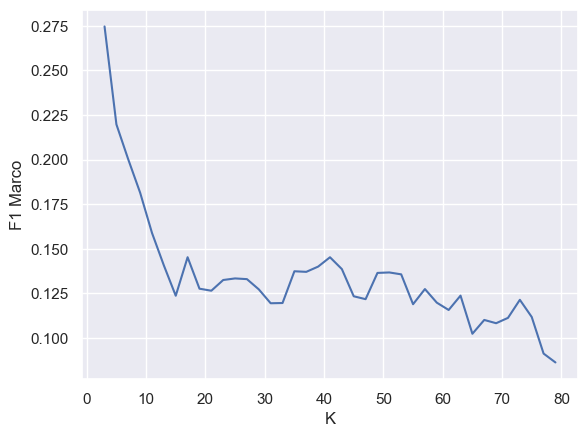

'\nk = 3 have the higest f1 score\n\n'

In [24]:
F1 = {}
for k in range(3, 80, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_resampled)
    y_pred = knn.predict(X_test_scaled)
    F1[k] = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
    
# PLotting K v/s accuracy graph
plt.plot(range(3,80,2), F1.values())
plt.xlabel('K')
plt.ylabel('F1 Marco')
plt.show()


'''
k = 3 have the higest f1 score

'''

In [25]:
from sklearn.metrics import accuracy_score, classification_report
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_resampled)
y_pred = knn.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("KNN F1 Macro:", f1_score(y_true=y_test, y_pred=y_pred, average='macro'))
print("KNN F1 Micro:", f1_score(y_true=y_test, y_pred=y_pred, average='micro'))

0.2919254658385093
              precision    recall  f1-score   support

           0       0.73      0.28      0.40        69
           1       0.27      0.31      0.29        29
           2       0.10      0.25      0.14        16
           3       0.29      0.33      0.31        30
           4       0.19      0.29      0.23        17

    accuracy                           0.29       161
   macro avg       0.32      0.29      0.27       161
weighted avg       0.45      0.29      0.32       161

KNN F1 Macro: 0.27466235093256075
KNN F1 Micro: 0.2919254658385093
